## Import Required Libraries

In [16]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from collections import Counter

# NLTK
import nltk
from nltk.tokenize import word_tokenize

# Spacy
import spacy
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

# Word Cloud
from wordcloud import WordCloud

## Load Dataset

In [5]:
# Read positive reviews
with open('Datasets/positive-reviews.txt', 'r', encoding='utf-8') as f:
    positive_reviews = f.readlines()

# Read negative reviews
with open('Datasets/negative-reviews.txt', 'r', encoding='utf-8') as f:
    negative_reviews = f.readlines()

In [7]:
positive_reviews[:10]

['Size, Size, ans Size.\n',
 'Excellent quality, speedy printing, low cost\n',
 'Cheap, good quality, small size\n',
 'Attractive design, satisfying features, the backlight!\n',
 'Pretty much has every feature you could possibly need, great look\n',
 'Ease of use, small size and reliability\n',
 'cheap,good print quality\n',
 'takes clear shots\n',
 'Small, Light, Stylish, backlight\n',
 'Absolutely Outstanding Photo Printing Results.  Easy to Use.\n']

In [8]:
negative_reviews[:10]

['Image quality not as good as some other brands, cheap feel to body.\n',
 'nothing\n',
 'Black text could be better, ink runs out kind of fast\n',
 "The thing won't work\n",
 'Display grainy, small keypad for text messaging, poor vibrate function\n',
 "Unfriendly user interface, not alot of features, Qwest's service`\n",
 'Only Serial Connection, No Optical Zoom, Bulky\n',
 'noise, the fact that it broke\n',
 'flip button difficult to press at times\n',
 'Voice quality patchy, Web service very patchy\n']

In [11]:
# Combine positive and negative review into one Dataset 
data = pd.DataFrame({'review_text': positive_reviews + negative_reviews,
                     'label': [1] * len(positive_reviews) + [0] * len(negative_reviews)})

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

data

,review_text,label
0,"prints fast, ink lasts a long time, visually p...",1
1,"Great software, powerful functions.\n",1
2,"Neat color screen, ring tones and wallpaper. P...",1
3,"SO stylish, AWESOME features!!\n",1
4,"soft focusing, LCD needed for everything\n",0
...,...,...
39995,Almost everything.\n,1
39996,Easy to push and turns great.\n,1
39997,"Small, handsome, full function, exceeds basic ...",1
39998,"Fast, good color, small margins.\n",1


## Data Exploration

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  40000 non-null  object
 1   label        40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


Label Distribution:
label
1    20000
0    20000
Name: count, dtype: int64


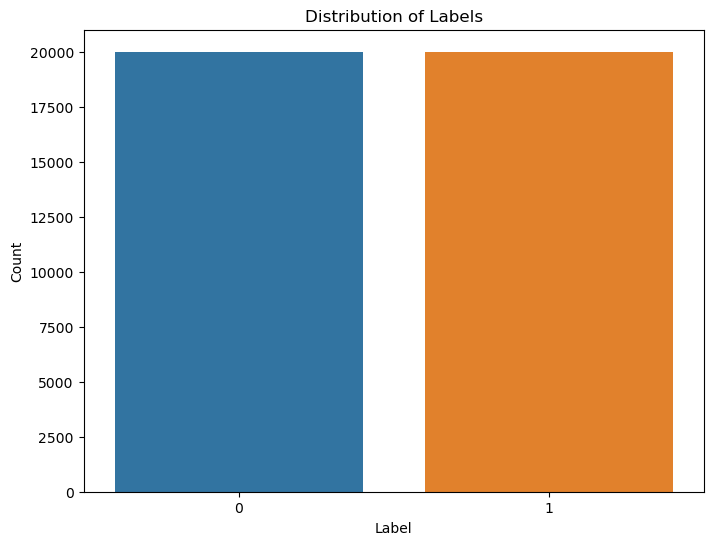

In [14]:
# Data Distribution
label_distribution = data['label'].value_counts()
print("Label Distribution:")
print(label_distribution)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

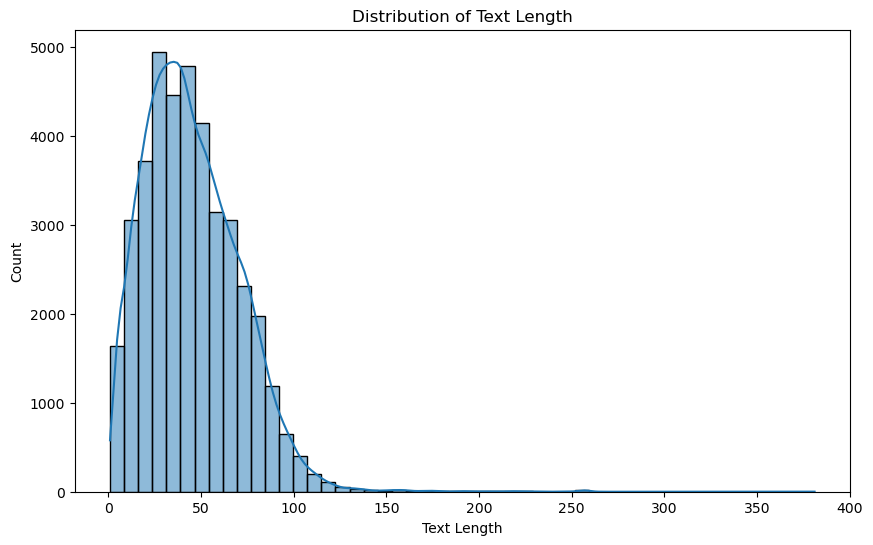

In [15]:
# Plotting text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['review_text'].apply(len), bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

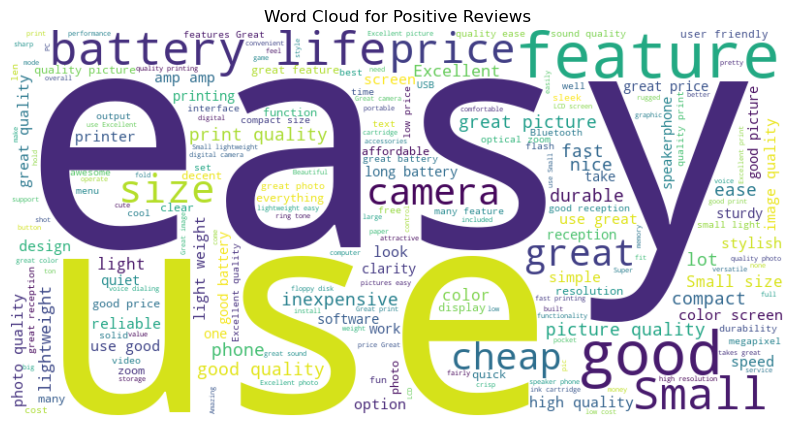

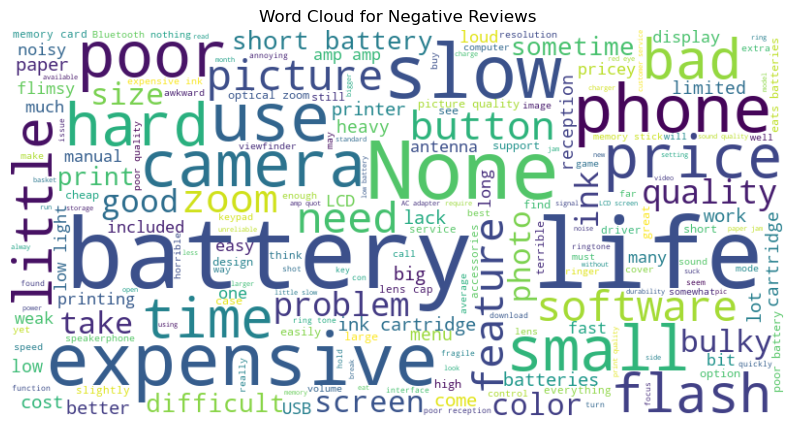

In [17]:
# Word Frequency Analysis
# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extracting positive and negative reviews
positive_reviews = ' '.join(data[data['label'] == 1]['review_text'])
negative_reviews = ' '.join(data[data['label'] == 0]['review_text'])

# Plotting word clouds for positive and negative reviews
plot_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
plot_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

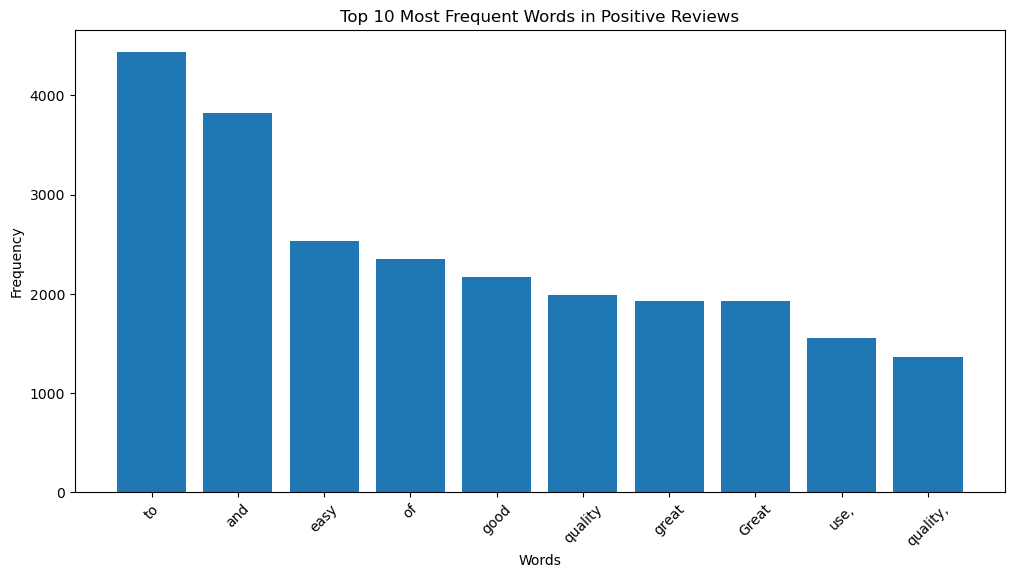

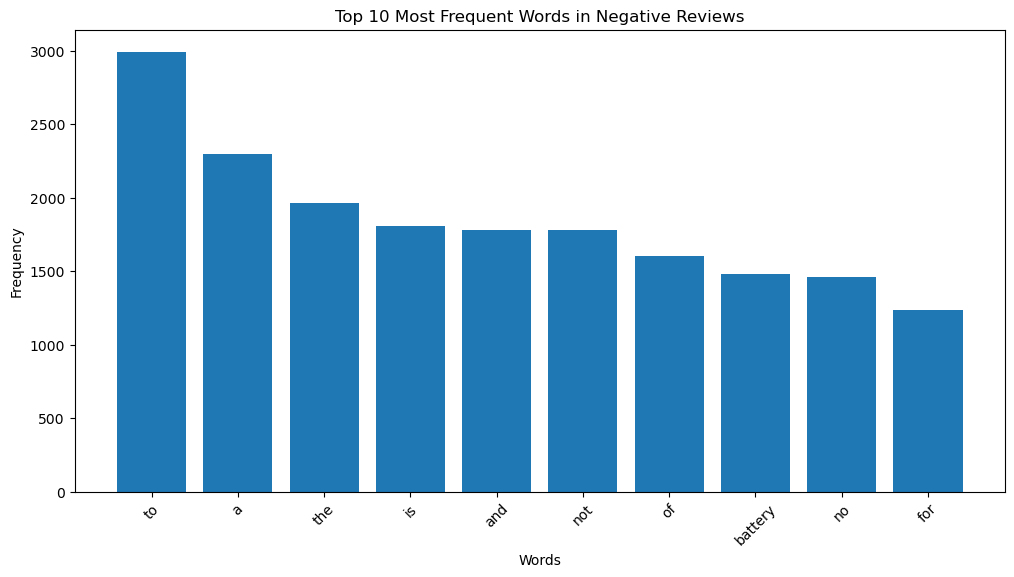

In [21]:
def plot_top_words_frequency(tokens, title):
    word_freq = Counter(tokens)
    top_words, top_freq = zip(*word_freq.most_common(10))
    
    plt.figure(figsize=(12, 6))
    plt.bar(top_words, top_freq)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Split the reviews
positive_tokens = ' '.join(data[data['label'] == 1]['review_text']).split()
negative_tokens = ' '.join(data[data['label'] == 0]['review_text']).split()

# Plot top 10 most frequent words in positive reviews
plot_top_words_frequency(positive_tokens, 'Top 10 Most Frequent Words in Positive Reviews')

# Plot top 10 most frequent words in negative reviews
plot_top_words_frequency(negative_tokens, 'Top 10 Most Frequent Words in Negative Reviews')
